<a href="https://colab.research.google.com/github/jhj1111/catid_ws/blob/main/simple_identifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ultralytics
!pip install torch torchvision
!pip install yt-dlp  # 유튜브 다운로드 라이브러리

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [ ]:
import yt_dlp

def download_youtube_video(youtube_url, output_path="video.mp4"):
    ydl_opts = {
        'format': 'bestvideo[ext=mp4]+bestaudio[ext=m4a]/mp4',
        'outtmpl': output_path,
        'quiet': True,
    }
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        ydl.download([youtube_url])

# 예시 링크 (짧은 고양이 영상으로 테스트하세요)
youtube_link = 'https://www.youtube.com/watch?v=FhA37Sw4j8w'  # 여기에 실제 링크 넣기
# youtube_link = 'https://www.youtube.com/watch?v=NRmCSplq09o'  # 여기에 실제 링크 넣기
download_youtube_video(youtube_link)

In [ ]:
youtube_link = 'https://www.youtube.com/watch?v=NRmCSplq09o'  # 여기에 실제 링크 넣기
download_youtube_video(youtube_link, output_path='video2.mp4')

# import

In [ ]:
import cv2
import torch
import numpy as np
from ultralytics import YOLO
from torchvision import models, transforms
from scipy.spatial.distance import cosine

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# 1. 모델 로드
yolo_model = YOLO('yolov8n.pt')  # 경량 모델
reid_model = models.resnet50(pretrained=True)
reid_model.fc = torch.nn.Identity()
reid_model.eval()

# 2. 이미지 전처리 (ReID용)
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# 3. 등록된 고양이 벡터 저장소
gallery_db = {}  # {id: embedding}
# global next_id
# next_id = 1


100%|██████████| 6.25M/6.25M [00:00<00:00, 19.9MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 82.8MB/s]


In [ ]:
def extract_feature(crop_img):
    """Re-ID용 특징 추출"""
    input_tensor = preprocess(crop_img).unsqueeze(0)
    with torch.no_grad():
        feature = reid_model(input_tensor)
    return feature.squeeze().numpy()


def find_matching_id(new_vec, threshold=0.4):
    """기존 벡터와 유사한 ID 찾기"""
    for cat_id, vec in gallery_db.items():
        if cosine(new_vec, vec) < threshold:
            return cat_id
    return None

In [ ]:
from glob import glob

glob('*.mp4')

['video2.mp4', 'video.mp4']

In [ ]:
from IPython.display import HTML



from base64 import b64encode



mp4 = open('video.mp4','rb').read()



data_url = "data:video/mp4;base64," + b64encode(mp4).decode()



HTML("""



<video width=500 controls>



      <source src="%s" type="video/mp4">



</video>



""" % data_url)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -R /content/drive/MyDrive/imgs /content

In [ ]:
gallery_db.clear()

In [ ]:
# 예: "고양이_1"이라는 고양이를 미리 등록
targets = glob('imgs/*')

for target in targets:
    cat_crop = cv2.imread(target)
    cat_vec = extract_feature(cat_crop)
    gallery_db[target.split('.')[0]] = cat_vec

In [ ]:
gallery_db

{'imgs/choco': array([    0.32835,    0.014751,     0.45391, ...,      1.1002,     0.04571,     0.45485], dtype=float32),
 'imgs/enjotic': array([    0.69168,     0.23976,     0.12893, ...,       1.247,     0.36291,     0.21106], dtype=float32),
 'imgs/goonbam': array([    0.13145,     0.81396,   0.0051967, ...,      0.1838,     0.14308,     0.48843], dtype=float32),
 'imgs/ddangcong': array([   0.079637,     0.59215,     0.12477, ...,     0.17832,      0.3194,     0.07821], dtype=float32),
 'imgs/leo': array([    0.71094,     0.30241,     0.21161, ...,       1.267,     0.36155,     0.42564], dtype=float32)}

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
next_id = 1

# 입력 및 출력 설정
input_path = "/content/video2.mp4"
output_path = "output_result.mp4"

cap = cv2.VideoCapture(input_path)
fps = cap.get(cv2.CAP_PROP_FPS)
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
# fourcc = cv2.VideoWriter_fourcc(*'DIVX')
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
# out = cv2.VideoWriter(output_path, fourcc, 30, (640, 480))

# frame_limit = float('inf')  # 예시: 100프레임까지만 처리
frame_limit = 30*100  # 예시: 100프레임까지만 처리
frame_count = 0

while cap.isOpened() and frame_count < frame_limit:
    ret, frame = cap.read()
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = yolo_model(frame_rgb)[0]
    boxes = results.boxes.xyxy.to(device).numpy()
    classes = results.boxes.cls.to(device).numpy()

    for i, box in enumerate(boxes):
        cls = int(classes[i])
        if cls != 15:
            continue
        x1, y1, x2, y2 = map(int, box)
        crop = frame_rgb[y1:y2, x1:x2]
        reid_vec = extract_feature(crop)
        matched_id = find_matching_id(reid_vec)

        # global next_id
        if matched_id is None:
            matched_id = f"cat_{next_id}"
            gallery_db[matched_id] = reid_vec
            next_id += 1

        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(frame, matched_id, (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    out.write(frame)
    frame_count += 1

cap.release()
out.release()


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
0: 384x640 1 vase, 153.7ms
Speed: 4.3ms preprocess, 153.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 vase, 142.3ms
Speed: 5.0ms preprocess, 142.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 vase, 148.0ms
Speed: 4.4ms preprocess, 148.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 vase, 159.6ms
Speed: 4.2ms preprocess, 159.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 vase, 141.7ms
Speed: 4.5ms preprocess, 141.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 vase, 141.3ms
Speed: 4.4ms preprocess, 141.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 vase, 147.0ms
Speed: 4.5ms preprocess, 147.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 cup, 1 vase, 145.7ms
Speed: 4.5ms preprocess, 145.7ms inference, 1.4m

In [ ]:
from IPython.display import HTML
from base64 import b64encode

mp4 = open("output_result.mp4",'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML(f"""
<video width=640 controls>
  <source src="{data_url}" type="video/mp4">
</video>
""")

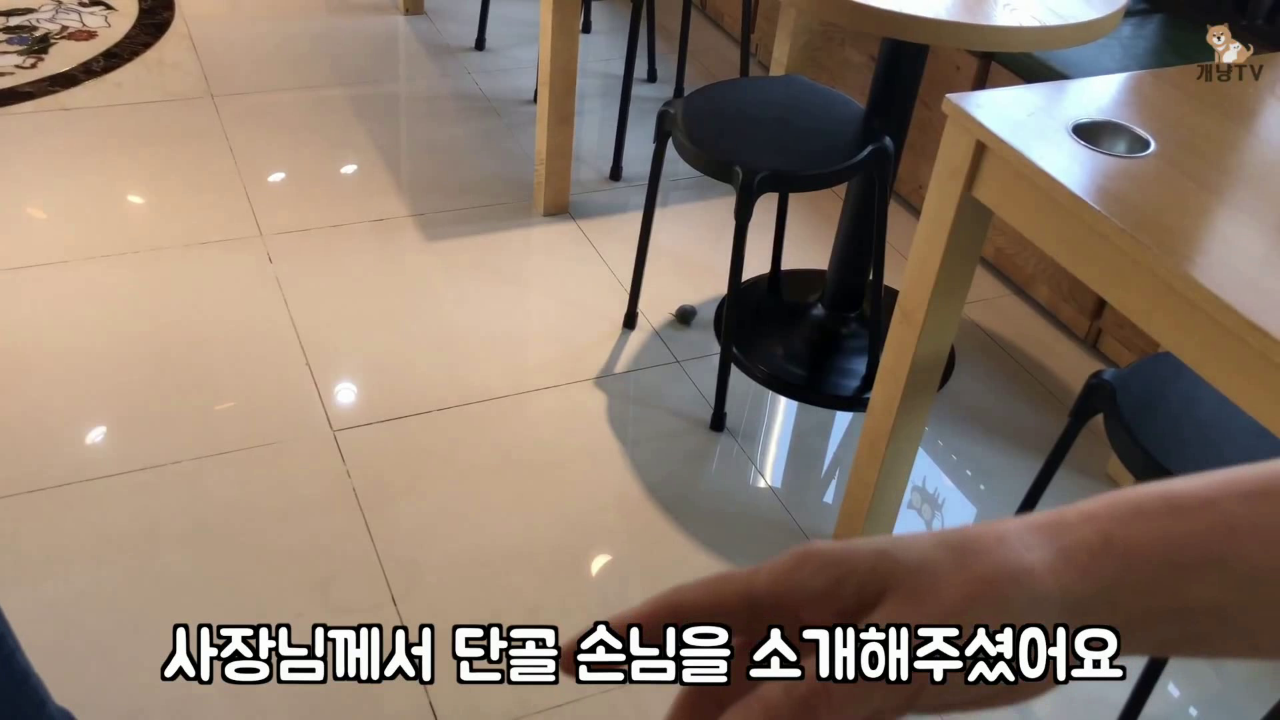

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
from IPython.display import clear_output, Image
import time

cap = cv2.VideoCapture('output_result.mp4')
fps = 300

while cap.isOpened():
#while True:
  ok, frame = cap.read()

  if not ok:
    break

  if ok:
    #edit your video size here, to adjust the performance
    largura=frame.shape[1]
    altura=frame.shape[0]
    lamenor=int(frame.shape[1]*2/3)
    altmenor=int(frame.shape[0]*2/3)
    frame = cv2.resize(frame, (lamenor,altmenor))

    # as you read
    clear_output(wait=True)
    cv2_imshow(frame)
    #delay time to update frame
    #time.sleep(1.1)
    # time.sleep(1/fps)

  # if cv2.waitKey(100) & 0xFF == ord('q'):
  #   break

cap.release()
cv2.destroyAllWindows()